In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
!git clone https://github.com/MdRabbi3261/CNN_Image_Classification.git


Cloning into 'CNN_Image_Classification'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 0), reused 17 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.96 MiB | 34.09 MiB/s, done.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [4]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [5]:
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.99MB/s]


In [6]:
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
num_epochs = 5
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(100 * correct / total)

    # Validation
    model.eval()
    correct, total, vloss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            vloss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss.append(vloss / len(test_loader))
    val_acc.append(100 * correct / total)

    print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.2f}%, Val Acc={val_acc[-1]:.2f}%")


Epoch 1: Train Acc=83.01%, Val Acc=86.83%
Epoch 2: Train Acc=88.42%, Val Acc=88.46%
Epoch 3: Train Acc=90.34%, Val Acc=88.31%
Epoch 4: Train Acc=91.60%, Val Acc=89.16%
Epoch 5: Train Acc=92.46%, Val Acc=90.55%


In [10]:
os.makedirs("CNN_Image_Classification/model", exist_ok=True)
torch.save(model.state_dict(), "CNN_Image_Classification/model/210106.pth")


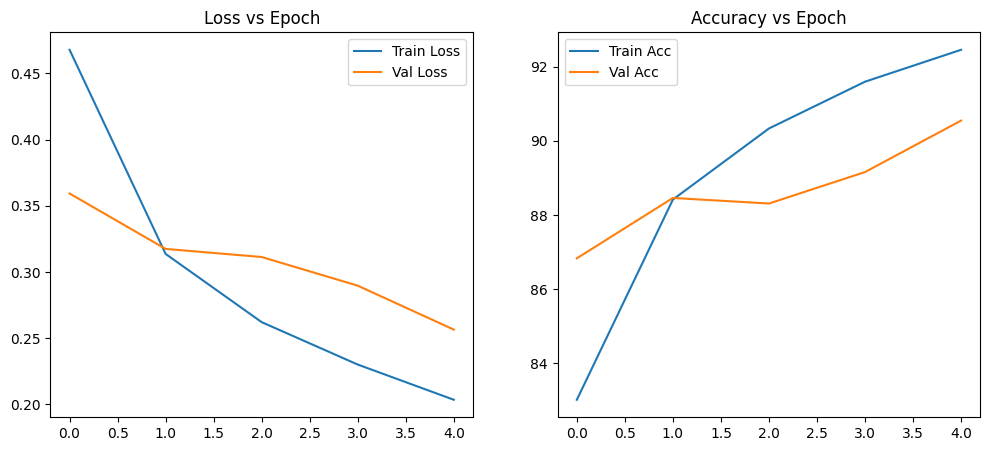

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss vs Epoch")

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy vs Epoch")

plt.show()


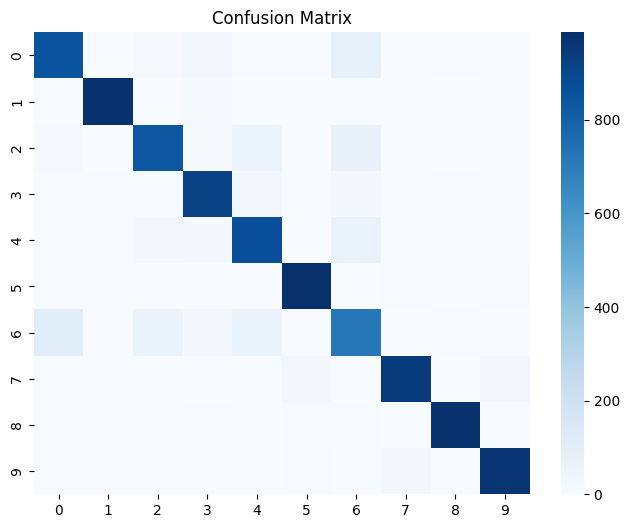

In [12]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


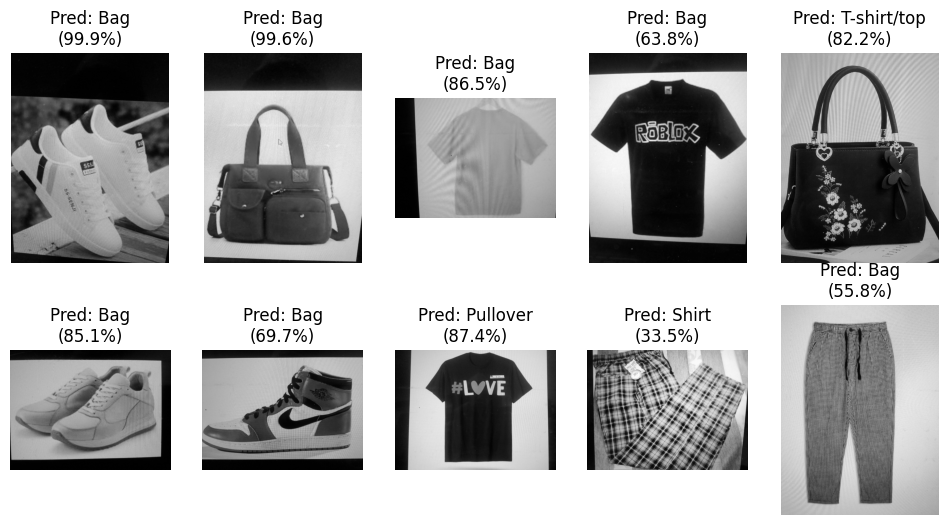

In [14]:
custom_dir = "CNN_Image_Classification/dataset"
custom_images = os.listdir(custom_dir)
plt.figure(figsize=(12,6))

for i, img_name in enumerate(custom_images):
    img_path = os.path.join(custom_dir, img_name)
    image = Image.open(img_path)
    image_t = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_t)
        prob = torch.softmax(output, dim=1)
        conf, pred = torch.max(prob, 1)

    plt.subplot(2,5,i+1)
    plt.imshow(image.convert("L"), cmap="gray")
    plt.title(f"Pred: {classes[pred.item()]}\n({conf.item()*100:.1f}%)")
    plt.axis("off")

plt.show()


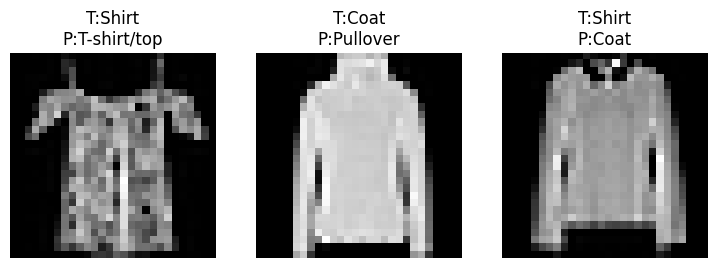

In [15]:
wrong = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        for img, t, p in zip(images, labels, preds):
            if t != p:
                wrong.append((img.cpu(), t.item(), p.item()))

samples = random.sample(wrong, 3)

plt.figure(figsize=(9,3))
for i, (img, t, p) in enumerate(samples):
    plt.subplot(1,3,i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"T:{classes[t]}\nP:{classes[p]}")
    plt.axis("off")
plt.show()

In [16]:
# from google.colab import files

# files.download("CNN_Image_Classification/model/210106.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>